In [1]:
import numpy as np, matplotlib.pyplot as plt, os
import tools21cm as t2c, py21cmfast as p21c
from py21cmfast import plotting
import random, zipfile
from astropy.cosmology import FlatLambdaCDM
from tqdm import tqdm

import matplotlib.gridspec as gridspec

from itertools import permutations
from datetime import datetime

# create seed for 21cmFast
str_seed = [var for var in datetime.now().strftime('%d%H%M%S')]
np.random.shuffle(str_seed)
seed = int(''.join(str_seed))

#outpath = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/test_predict/'
outpath = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions_1/layers_output/data/'

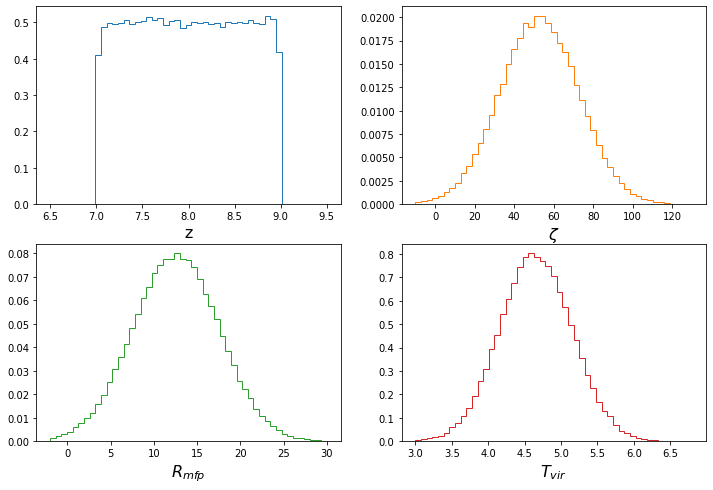

(None, None, None)

<Figure size 432x288 with 0 Axes>

In [2]:
redshift = np.random.uniform(7, 9, 100000)
eff_fact = [random.gauss(52.5, 20.) for i in range(100000)]
Rmfp = [random.gauss(12.5, 5.) for i in range(100000)]
Tvir = [random.gauss(4.65, 0.5) for i in range(100000)]

fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs[0,0].hist(redshift, np.linspace(6.5,9.5), density=True, histtype='step', color='tab:blue');
axs[0,1].hist(eff_fact, np.linspace(-10,130), density=True, histtype='step', color='tab:orange');
axs[1,0].hist(Rmfp, np.linspace(-2,30), density=True, histtype='step', color='tab:green');
axs[1,1].hist(Tvir, np.linspace(3,6.8), density=True, histtype='step', color='tab:red');
axs[0,0].set_xlabel(r'z', size=16)
axs[0,1].set_xlabel(r'$\zeta$', size=16)
axs[1,0].set_xlabel(r'$R_{mfp}$', size=16)
axs[1,1].set_xlabel(r'$T_{vir}$', size=16);
plt.savefig(outpath+'astro_params_stat.png', bbox_inches='tight'), plt.show(), plt.clf()

## Create coeval cubes
Here we create the 21cmFast cube outputs 

In [47]:
sim = 'tobs1000'
index = 99

if(sim == '21cmFAST'):
    z = 8.939   
    zeta = 65.204
    Rmfp = 11.861
    Tvir = 4.539

    params = {'HII_DIM':128, 'DIM':384, 'BOX_LEN':256}
    my_ext = [0, params['BOX_LEN'], 0, params['BOX_LEN']]

    c_params = {'OMm':0.27, 'OMb':0.046, 'SIGMA_8':0.82, 'POWER_INDEX':0.96}
    a_params = {'HII_EFF_FACTOR':zeta, 'R_BUBBLE_MAX':Rmfp, 'ION_Tvir_MIN':Tvir}

    ic = p21c.initial_conditions(user_params=params, cosmo_params=c_params, random_seed=2021)
    cube = p21c.run_coeval(redshift=z, init_box=ic, astro_params=a_params, zprime_step_factor=1.05)
    
    dT = cube.brightness_temp
    xH = cube.xH_box
    
    name = ''
    
    print('z = %.3f  x_n = %.3f  zeta = %.3f  R_mfp = %.3f  T_vir = %.3f' %(z, np.mean(cube.xH_box), zeta, Rmfp, Tvir))
elif(sim == 'tobs1000'):
    PATH_INPUT = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/data3D_128_061020/tobs1000.zip'
    PATH_IN_ZIP = PATH_INPUT[PATH_INPUT.rfind('/')+1:-4]+'/'
    PATH_UNZIP = PATH_INPUT[:PATH_INPUT.rfind('/')+1]

    params = {'HII_DIM':128, 'DIM':384, 'BOX_LEN':256}
    my_ext = [0, params['BOX_LEN'], 0, params['BOX_LEN']]

    c_params = {'OMm':0.27, 'OMb':0.046, 'SIGMA_8':0.82, 'POWER_INDEX':0.96}
    
    with zipfile.ZipFile(PATH_INPUT, 'r') as myzip:
        astr_data = np.loadtxt(myzip.open('%sastro_params.txt' %PATH_IN_ZIP))[index]
        
        f = myzip.extract(member='%simage_21cm_i%d.bin' %(PATH_IN_ZIP+'data/', index), path=PATH_UNZIP)
        dT3 = t2c.read_cbin(f) 
        f = myzip.extract(member='%smask_21cm_i%d.bin' %(PATH_IN_ZIP+'data/', index), path=PATH_UNZIP)
        mask_xn = t2c.read_cbin(f) 
        os.system('rm -r %s/' %(PATH_UNZIP+PATH_IN_ZIP))
        #print('z = %.3f  x_n = %.3f  zeta = %.3f  R_mfp = %.3f  T_vir = %.3f' %(z, 1-np.mean(xi), zeta, Rmfp, Tvir))
    
    z, zeta, Rmfp, Tvir, xn = astr_data[1:]
    print('z = %.3f  x_n = %.3f  zeta = %.3f  R_mfp = %.3f  T_vir = %.3f' %(z, xn, zeta, Rmfp, Tvir))
    print('xn_mask = %.3f' %np.mean(mask_xn))
    name = '_i%d' %index
    
elif(sim == 'C2Ray'):
    zeta = 0.0
    Rmfp = 0.0
    Tvir = 0.0
    z = 8.397
    
    pathLB = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/244Mpc_f2_8.2pS_500/'

    params = {'HII_DIM':128, 'BOX_LEN':128*2.057}
    c_params = {'OMm':0.27, 'OMb':0.046, 'SIGMA_8':0.82, 'POWER_INDEX':0.96}
    my_ext = [0, params['BOX_LEN'], 0, params['BOX_LEN']]

    #dT = t2c.read_cbin('%sdTb_cbin_z%.3f.dat' %(pathLB, z))[0:params['HII_DIM'],0:params['HII_DIM'],0:params['HII_DIM']]
    n_all = t2c.read_cbin('%s%.3fn_all_r2.09.bin' %(pathLB, z))[0:params['HII_DIM'],0:params['HII_DIM'],0:params['HII_DIM']]
    xi = t2c.read_cbin('%sxfrac3d_%.3f_r2.09.bin' %(pathLB, z))[0:params['HII_DIM'],0:params['HII_DIM'],0:params['HII_DIM']]
    
    dT = t2c.calc_dt(xfrac=xi, dens=n_all, z=z)
    xH = 1-xi
    
    name = '_244Mpc_z%.3f_r2.09' %z
    
    print('z = %.3f  x_n = %.3f  zeta = %.3f  R_mfp = %.3f  T_vir = %.3f' %(z, 1-np.mean(xi), zeta, Rmfp, Tvir))

cosmo = FlatLambdaCDM(H0=70., Ob0=c_params['OMb'], Om0=c_params['OMm'])

z = 7.030  x_n = 0.724  zeta = 52.803  R_mfp = 12.839  T_vir = 5.229
xn_mask = 0.813


## Differential Brightness
Calculate the differential brightness temperature $\delta T_{b}$ assuming $T_S\gg T_{CMB}$ (heating approximation or saturated limit)

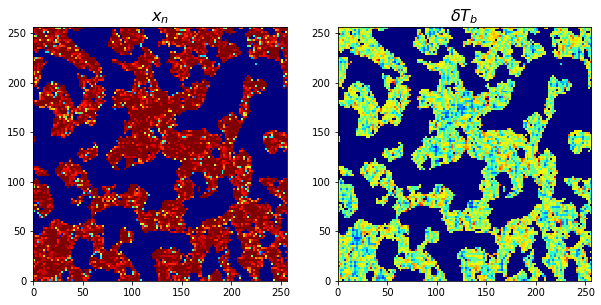

In [3]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(121)
plt.title('$x_n$', size=16)
plt.imshow(xH[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext, interpolation='nearest')
plt.subplot(122)
plt.title(r'$\delta T_b$', size=16)
plt.imshow(dT[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext, interpolation='nearest')

## Plot spherically averaged power spectrum

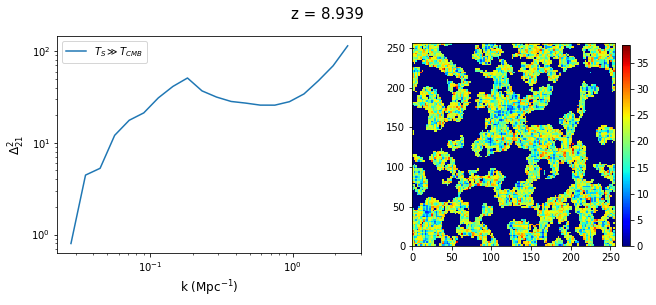

In [4]:
ps, ks, n_modes = t2c.power_spectrum_1d(dT, kbins=20, box_dims=params['BOX_LEN'],
                                        return_n_modes=True, binning='log')

fig = plt.figure(figsize=(10, 4))
fig.suptitle('z = %.3f' %z, fontsize=15)
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1.5, 1])
ax0 = fig.add_subplot(gs[0,0])
ax0.loglog(ks, ps*ks**3/2/np.pi**2, 'tab:blue', label=r'$T_S \gg T_{CMB}$')
ax0.set_xlabel('k (Mpc$^{-1}$)', fontsize=12), ax0.set_ylabel('$\Delta^2_\mathrm{21}$', fontsize=12)
ax1 = fig.add_subplot(gs[0,1])
im = ax1.imshow(dT[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext)
ax0.legend()
plt.colorbar(im, ax=ax1, cax=fig.add_axes([0.91, 0.15, 0.01, 0.7]))

## Telescope noise calculation. 
Calculation of the uv-coverage. See https://arxiv.org/abs/1607.02779 & https://arxiv.org/abs/1801.06550 

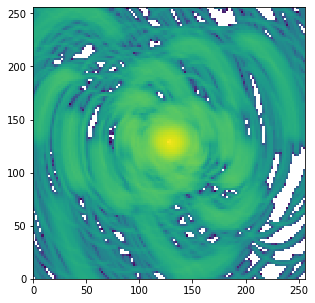

In [5]:
import pickle

uvfile = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/uvmap_128_z7-20.pkl'
if not (os.path.exists(uvfile)):
    print('uv-map pickle not found')
else:
    uvs = pickle.load(open(uvfile, 'rb'))

uv = uvs['%.3f' %z]
Nant = uvs['Nant']

plt.figure(figsize=(15, 5))
plt.imshow(np.log10(np.fft.fftshift(uv)), origin='lower', extent=my_ext)

### Creating the noise cube

In [6]:
tobs = 1000

np.random.seed(seed)
noise_cube = t2c.noise_cube_coeval(params['HII_DIM'], z,
                                   depth_mhz=None,   #If None, estimates the value such that the final output is a cube.
                                   obs_time=tobs, filename=None, boxsize=params['BOX_LEN'],
                                   total_int_time=6.0, int_time=10.0, declination=-30.0, uv_map=uv,
                                   N_ant=Nant, verbose=True, fft_wrap=False)


Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 354.65it/s]

...noise cube created.


Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 374.27it/s]


...noise cube created.
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 344.11it/s]


...noise cube created.
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 351.35it/s]


...noise cube created.
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 352.25it/s]


...noise cube created.
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 367.69it/s]


...noise cube created.


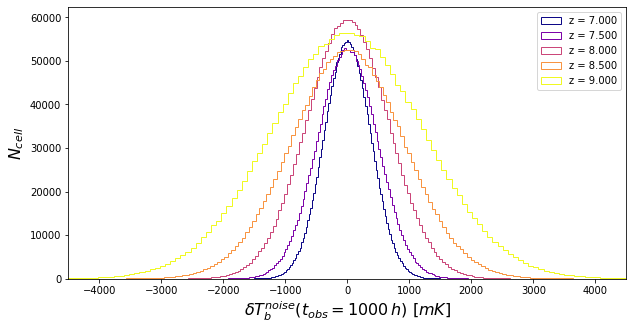

(None, None, None)

<Figure size 720x360 with 0 Axes>

In [7]:
import pickle, matplotlib

redshift = np.arange(7.000, 9.001, 0.001)

norm = matplotlib.colors.Normalize(vmin=redshift.min(), vmax=redshift.max(), clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap='plasma')
plt.figure(figsize=(10,5))
for zn in [7.0, 7.5, 8.0, 8.5, 9.0]:
    uvfile = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/uvmap_128_z7-20.pkl'
    if not (os.path.exists(uvfile)):
        print('uv-map pickle not found')
    else:
        uvs = pickle.load(open(uvfile, 'rb'))

    uv = uvs['%.3f' %zn]
    Nant = uvs['Nant']
    tobs = 1000
    np.random.seed(seed)
    noise_cube = t2c.noise_cube_coeval(params['HII_DIM'], zn,
                                       depth_mhz=None,   #If None, estimates the value such that the final output is a cube.
                                       obs_time=tobs, filename=None, boxsize=params['BOX_LEN'],
                                       total_int_time=6.0, int_time=10.0, declination=-30.0, uv_map=uv,
                                       N_ant=Nant, verbose=True, fft_wrap=False)


    plt.hist(noise_cube.flatten(), bins=150, histtype='step', color=mapper.to_rgba(zn), label='z = %.3f' %zn)

plt.xlim(-4500,4500)
plt.ylabel(r'$N_{cell}$', size=16)
plt.xlabel(r'$\delta T_b^{noise}(t_{obs}=1000\,h)$ $[mK]$', size=16)
plt.legend()
plt.savefig('%snoise%s.png' %(outpath, name), bbox_inches='tight'), plt.show(), plt.clf()

In [8]:
dT1 = t2c.subtract_mean_signal(dT, los_axis=2)
dT2 = dT1 + noise_cube

# Smooth the data to resolution corresponding to maximum baseline of 2 km
dT3 = t2c.smooth_coeval(dT2, z, box_size_mpc=params['HII_DIM'], max_baseline=2.0, ratio=1.0, nu_axis=2)

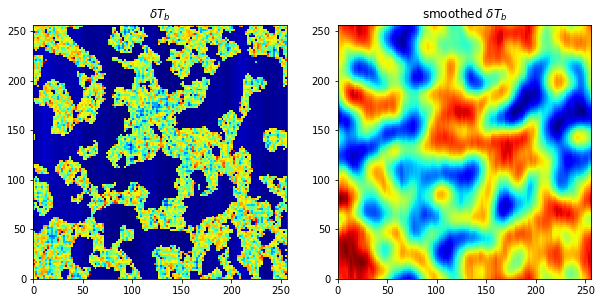

In [9]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(121)
plt.title('$\delta T_b$')
plt.imshow(dT1[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext, interpolation='nearest')
plt.subplot(122)
plt.title('smoothed $\delta T_b$')
plt.imshow(dT3[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext, interpolation='nearest')

sim x_n = 0.5002
smt x_n = 0.5002
mask x_n = 0.5222


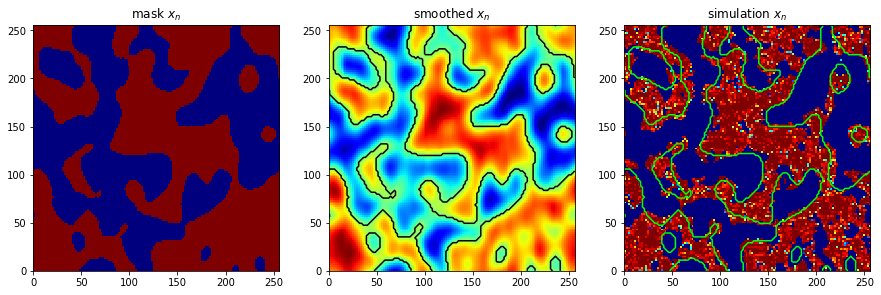

In [10]:
smt_xn = t2c.smooth_coeval(xH, z, box_size_mpc=params['HII_DIM'], max_baseline=2.0, ratio=1.0, nu_axis=2)
mask_xn = smt_xn>0.5

print('sim x_n = %.4f' %np.mean(xH))
print('smt x_n = %.4f' %np.mean(smt_xn))
print('mask x_n = %.4f' %np.mean(mask_xn))

plt.rcParams['figure.figsize'] = [15, 5]
plt.subplot(131)
plt.title('mask $x_n$')
plt.imshow(mask_xn[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext)
plt.subplot(132)
plt.title('smoothed $x_n$')
plt.contour(mask_xn[:,params['HII_DIM']//2,:], colors='k', levels=[0.5], extent=my_ext)
plt.imshow(smt_xn[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext)
plt.subplot(133)
plt.title('simulation $x_n$')
plt.contour(mask_xn[:,params['HII_DIM']//2,:], colors='lime', levels=[0.5], extent=my_ext)
plt.imshow(xH[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext)

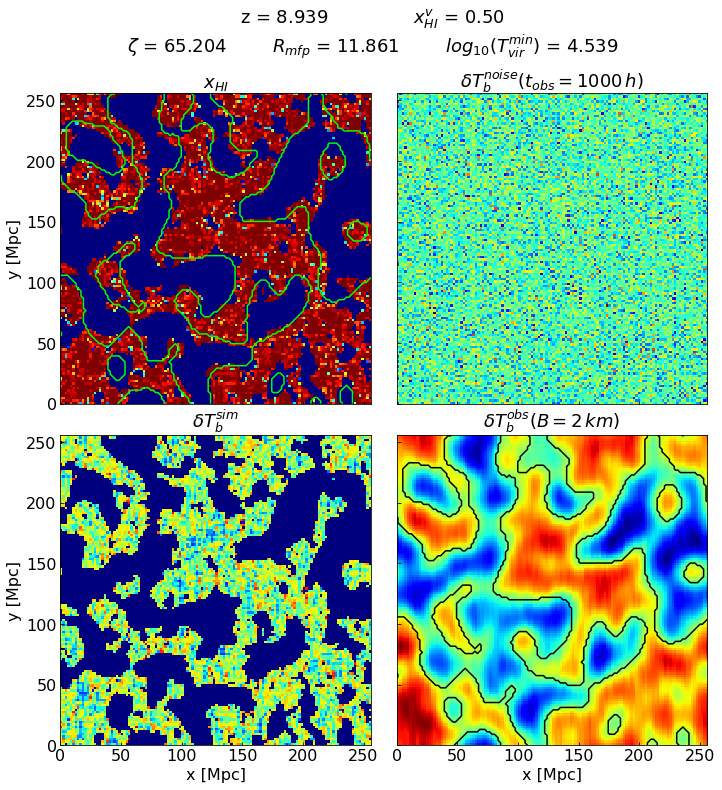

(None, None, None)

<Figure size 1080x360 with 0 Axes>

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('z = %.3f\t\t$x^v_{HI}$ = %.2f\n$\zeta$ = %.3f        $R_{mfp}$ = %.3f        $log_{10}(T_{vir}^{min})$ = %.3f' %(z, np.mean(xH), zeta, Rmfp, Tvir), fontsize=18)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 16

axs[0,0].set_title('$x_{HI}$', size=18)
axs[0,0].contour(mask_xn[:,params['HII_DIM']//2,:], colors='lime', levels=[0.5], extent=my_ext)
axs[0,0].imshow(xH[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext)
axs[0,0].set_ylabel('y [Mpc]');

axs[0,1].set_title('$\delta T^{noise}_b(t_{obs}=%d\,h)$' %tobs, size=18)
axs[0,1].imshow(dT2[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext)

axs[1,0].set_title('$\delta T^{sim}_b$', size=18)
axs[1,0].imshow(dT[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext)
axs[1,0].set_xlabel('x [Mpc]'), axs[1,0].set_ylabel('y [Mpc]');

axs[1,1].set_title('$\delta T^{obs}_b(B=2\,km)$', size=18)
axs[1,1].imshow(dT3[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext)
axs[1,1].contour(mask_xn[:,params['HII_DIM']//2,:], colors='k', levels=[0.5], extent=my_ext)
axs[1,1].set_xlabel('x [Mpc]')

plt.subplots_adjust(hspace=0.1, wspace=0.01)
for ax in axs.flat: ax.label_outer()

plt.savefig('%scube21cm%s.png' %(outpath, name), bbox_inches='tight'), plt.show(), plt.clf()

## Load SegUnet best model

In [48]:
import matplotlib.pyplot as plt, numpy as np
import tools21cm as t2c
from matplotlib import gridspec

plt.rcParams['font.size'] = 20
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.linewidth'] = 1.2
ls = 22

In [49]:
from tensorflow.keras.models import load_model
from utils_network.metrics import iou, iou_loss, dice_coef, dice_coef_loss, balanced_cross_entropy, phi_coef
from config.net_config import NetworkConfig

def LoadSegUnetModel(cfile):
    avail_metrics = {'binary_accuracy':'binary_accuracy', 'iou':iou, 'dice_coef':dice_coef, 'iou_loss':iou_loss, 'dice_coef_loss':dice_coef_loss, 'phi_coef':phi_coef, 'mse':'mse', 'mae':'mae', 'binary_crossentropy':'binary_crossentropy', 'balanced_cross_entropy':balanced_cross_entropy}
    conf = NetworkConfig(conf_file)

    PATH_OUT = conf.resume_path
    MODEL_EPOCH = conf.best_epoch
    METRICS = [avail_metrics[m] for m in np.append(conf.loss, conf.metrics)]
    cb = {func.__name__:func for func in METRICS if not isinstance(func, str)}
    model_loaded = load_model('%smodel-sem21cm_ep%d.h5' %(PATH_OUT+'checkpoints/', MODEL_EPOCH), custom_objects=cb)
    
    print(' Loaded model:\n %smodel-sem21cm_ep%d.h5' %(conf.resume_path, MODEL_EPOCH))
    return model_loaded

In [50]:
# load model
conf_file = '/home/michele/Documents/PhD_Sussex/output/ML/SegNet/tests/runs/'
#conf_file += 'net2D_201020.ini'
#conf_file += 'net2D_161020.ini'
conf_file += 'net2D_021020.ini'
model = LoadSegUnetModel(conf_file)

 Loaded model:
 /home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/model-sem21cm_ep56.h5


## Calculate Prediction

In [51]:
# SegUnet
from utils_network.prediction import SegUnet21cmPredict
from utils.other_utils import RescaleData

if(sim == 'C2Ray'):
    # a and b values are based on the training dataset
    dT3 = RescaleData(arr=dT3, a=-11, b=11)

X_tta = SegUnet21cmPredict(unet=model, x=dT3, TTA=True)
X_seg = np.round(np.mean(X_tta, axis=0))

100%|██████████| 32/32 [22:36<00:00, 39.68s/it]


In [52]:
# super-pixel
labels = t2c.slic_cube(dT3.astype(dtype='float64'), n_segments=5000, compactness=0.1, max_iter=20, sigma=0, min_size_factor=0.5, max_size_factor=3, cmap=None)
superpixel_map = t2c.superpixel_map(dT3, labels)
X_sp = 1-t2c.stitch_superpixels(dT3, labels, bins='knuth', binary=True, on_superpixel_map=True)

The output contains the labels created by SLIC with 5807 segments


In [53]:
from sklearn.metrics import matthews_corrcoef

phicoef_tta = np.zeros(X_tta.shape[0])
xn_tta = np.zeros(X_tta.shape[0])
for i in tqdm(range(len(X_tta))):
    x = X_tta[i]
    
    xn_tta[i] = np.mean(np.round(x))
    phicoef_tta[i] = matthews_corrcoef(mask_xn.flatten(), np.round(x).flatten())

xn_err = np.std(xn_tta)
phicoef_err = np.std(phicoef_tta)

phicoef_seg = matthews_corrcoef(mask_xn.flatten(), X_seg.flatten())
phicoef_sp = matthews_corrcoef(mask_xn.flatten(), X_sp.flatten())


100%|██████████| 96/96 [08:22<00:00,  4.01s/it]


In [54]:
print('x_n = %.4f\t\t(Mask)' %np.mean(mask_xn))
print('x_n = %.4f +/- %.4f\t(SegUnet)' %(np.mean(X_seg), xn_err))
print('x_n = %.4f\t\t(Superpixel)\n' %np.mean(X_sp))

print('phi_coef = %.3f +/- %.3f\t(SegUnet)' %(phicoef_seg, phicoef_err))
print('phi_coef = %.3f\t\t(Superpixel)' %phicoef_sp)

x_n = 0.8135		(Mask)
x_n = 0.8098 +/- 0.0029	(SegUnet)
x_n = 0.7481		(Superpixel)

phi_coef = 0.936 +/- 0.010	(SegUnet)
phi_coef = 0.768		(Superpixel)


## SegUnet Visual comparison

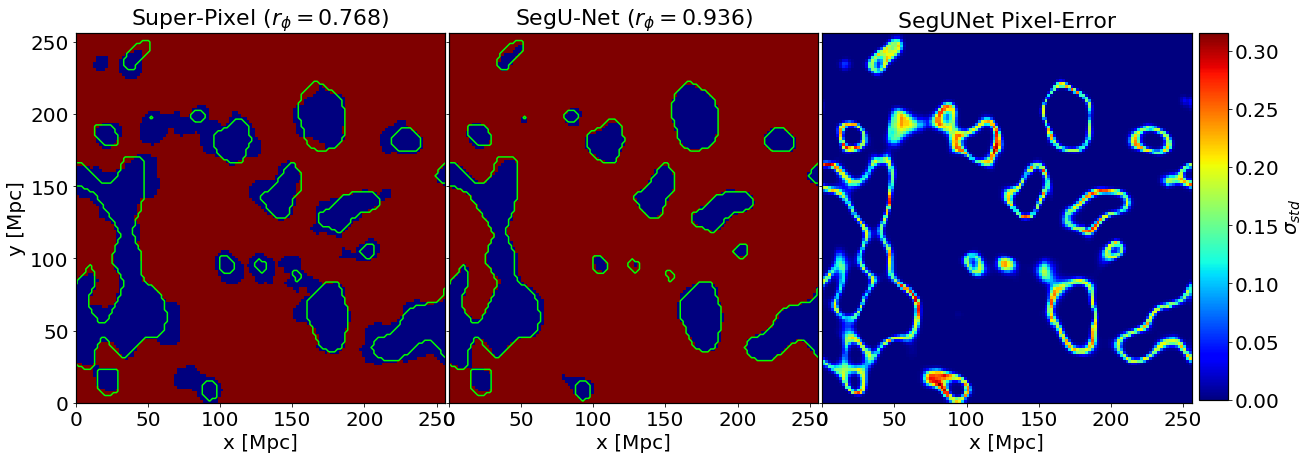

<Figure size 1440x720 with 0 Axes>

In [55]:
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['figure.figsize'] = [20, 10]

idx = params['HII_DIM']//2

X_seg_err = np.std(X_tta, axis=0)

fig, axs = plt.subplots(figsize=(20,10), ncols=3, sharey=True, sharex=True)
(ax0, ax1, ax2) = axs
ax0.set_title('Super-Pixel ($r_{\phi}=%.3f$)' %phicoef_sp, size=ls)
ax0.imshow(X_sp[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
ax0.contour(mask_xn[:,idx,:], colors='lime', levels=[0.5], extent=my_ext)
ax0.set_xlabel('x [Mpc]'), ax0.set_ylabel('y [Mpc]')

ax1.set_title('SegU-Net ($r_{\phi}=%.3f$)' %phicoef_seg, size=ls)
ax1.imshow(X_seg[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
ax1.contour(mask_xn[:,idx,:], colors='lime', levels=[0.5], extent=my_ext)
ax1.set_xlabel('x [Mpc]')

ax2.set_title('SegUNet Pixel-Error', size=ls)
im = plt.imshow(X_seg_err[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
fig.colorbar(im, label=r'$\sigma_{std}$', ax=ax2, pad=0.02, cax=fig.add_axes([0.905, 0.25, 0.02, 0.51]))
ax2.set_xlabel('x [Mpc]')

plt.subplots_adjust(hspace=0.1, wspace=0.01)
for ax in axs.flat: ax.label_outer()

plt.savefig('%svisual_comparison%s.png' %(outpath, name), bbox_inches='tight')

plt.show()
plt.clf()

## BSD - MFP

In [56]:
mfp_pred_ml = t2c.bubble_stats.mfp(X_seg, xth=0.5, boxsize=params['BOX_LEN'], iterations=2000000, verbose=False, upper_lim=False, bins=None, r_min=None, r_max=None)
mfp_pred_sp = t2c.bubble_stats.mfp(X_sp, xth=0.5, boxsize=params['BOX_LEN'], iterations=2000000, verbose=False, upper_lim=False, bins=None, r_min=None, r_max=None)
mfp_true = t2c.bubble_stats.mfp(mask_xn, xth=0.5, boxsize=params['BOX_LEN'], iterations=2000000, verbose=False, upper_lim=False, bins=None, r_min=None, r_max=None)  

mfp_tta = np.zeros((X_tta.shape[0], 2, 128))
for i in tqdm(range(0, X_tta.shape[0])):
    mfp_pred_ml1, mfp_pred_ml2 = t2c.bubble_stats.mfp(np.round(X_tta[i]), xth=0.5, boxsize=params['BOX_LEN'], iterations=2000000, verbose=False, upper_lim=False, bins=None, r_min=None, r_max=None)
    mfp_tta[i,0] = mfp_pred_ml1
    mfp_tta[i,1] = mfp_pred_ml2

MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 1.116372 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%
Program runtime: 1.063230 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

  0%|          | 0/96 [00:00<?, ?it/s]


Program runtime: 1.244482 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

  1%|          | 1/96 [01:34<2:30:09, 94.84s/it]


Program runtime: 1.580361 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

  2%|▏         | 2/96 [03:10<2:29:00, 95.12s/it]


Program runtime: 1.595660 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

  3%|▎         | 3/96 [04:32<2:21:09, 91.07s/it]


Program runtime: 1.360267 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

  4%|▍         | 4/96 [05:53<2:15:00, 88.05s/it]


Program runtime: 1.349785 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

  5%|▌         | 5/96 [07:26<2:15:58, 89.65s/it]


Program runtime: 1.555838 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

  6%|▋         | 6/96 [08:56<2:14:32, 89.70s/it]


Program runtime: 1.496514 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

  7%|▋         | 7/96 [10:05<2:03:49, 83.48s/it]


Program runtime: 1.149514 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

  8%|▊         | 8/96 [11:14<1:56:15, 79.27s/it]


Program runtime: 1.157028 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

  9%|▉         | 9/96 [12:36<1:55:51, 79.90s/it]


Program runtime: 1.356144 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 10%|█         | 10/96 [13:50<1:52:18, 78.35s/it]


Program runtime: 1.245191 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 11%|█▏        | 11/96 [14:57<1:45:47, 74.67s/it]


Program runtime: 1.101109 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 12%|█▎        | 12/96 [16:00<1:39:42, 71.23s/it]


Program runtime: 1.052851 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 14%|█▎        | 13/96 [17:02<1:34:37, 68.40s/it]


Program runtime: 1.030052 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 15%|█▍        | 14/96 [18:00<1:29:32, 65.52s/it]


Program runtime: 0.979697 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 16%|█▌        | 15/96 [19:01<1:26:22, 63.98s/it]


Program runtime: 1.006196 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 17%|█▋        | 16/96 [20:03<1:24:39, 63.49s/it]


Program runtime: 1.038861 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 18%|█▊        | 17/96 [21:08<1:23:59, 63.79s/it]


Program runtime: 1.074379 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 19%|█▉        | 18/96 [22:13<1:23:41, 64.38s/it]


Program runtime: 1.095768 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 20%|█▉        | 19/96 [23:17<1:22:17, 64.13s/it]


Program runtime: 1.058627 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 21%|██        | 20/96 [24:18<1:20:01, 63.18s/it]


Program runtime: 1.016068 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 22%|██▏       | 21/96 [25:23<1:19:32, 63.64s/it]


Program runtime: 1.078175 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 23%|██▎       | 22/96 [26:37<1:22:29, 66.88s/it]


Program runtime: 1.240484 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 24%|██▍       | 23/96 [27:59<1:26:53, 71.42s/it]


Program runtime: 1.366779 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 25%|██▌       | 24/96 [29:37<1:35:17, 79.41s/it]


Program runtime: 1.633990 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 26%|██▌       | 25/96 [31:13<1:39:47, 84.33s/it]


Program runtime: 1.596190 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 27%|██▋       | 26/96 [32:47<1:41:45, 87.22s/it]


Program runtime: 1.565926 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 28%|██▊       | 27/96 [34:26<1:44:27, 90.84s/it]


Program runtime: 1.654259 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 29%|██▉       | 28/96 [35:34<1:35:06, 83.92s/it]


Program runtime: 1.129354 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 30%|███       | 29/96 [36:42<1:28:30, 79.25s/it]


Program runtime: 1.139170 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 31%|███▏      | 30/96 [37:45<1:21:50, 74.40s/it]


Program runtime: 1.051045 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 32%|███▏      | 31/96 [38:53<1:18:34, 72.53s/it]


Program runtime: 1.135570 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 33%|███▎      | 32/96 [40:02<1:16:03, 71.30s/it]


Program runtime: 1.140285 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 34%|███▍      | 33/96 [41:11<1:14:03, 70.53s/it]


Program runtime: 1.145516 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 35%|███▌      | 34/96 [42:21<1:12:42, 70.36s/it]


Program runtime: 1.165560 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 36%|███▋      | 35/96 [43:20<1:08:04, 66.96s/it]


Program runtime: 0.983327 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 38%|███▊      | 36/96 [44:20<1:05:04, 65.08s/it]


Program runtime: 1.011431 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 39%|███▊      | 37/96 [45:19<1:02:10, 63.23s/it]


Program runtime: 0.981373 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 40%|███▉      | 38/96 [46:18<59:51, 61.92s/it]  


Program runtime: 0.981131 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 41%|████      | 39/96 [47:16<57:46, 60.82s/it]


Program runtime: 0.970708 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 42%|████▏     | 40/96 [48:15<56:16, 60.29s/it]


Program runtime: 0.983693 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 43%|████▎     | 41/96 [49:17<55:36, 60.67s/it]


Program runtime: 1.025885 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 44%|████▍     | 42/96 [50:15<53:48, 59.78s/it]


Program runtime: 0.961343 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 45%|████▍     | 43/96 [51:14<52:45, 59.72s/it]


Program runtime: 0.992816 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 46%|████▌     | 44/96 [52:10<50:39, 58.45s/it]


Program runtime: 0.924625 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 47%|████▋     | 45/96 [53:00<47:27, 55.84s/it]


Program runtime: 0.828937 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 48%|████▊     | 46/96 [53:48<44:36, 53.53s/it]


Program runtime: 0.802142 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 49%|████▉     | 47/96 [54:28<40:24, 49.48s/it]


Program runtime: 0.667226 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 50%|█████     | 48/96 [55:08<37:19, 46.66s/it]


Program runtime: 0.667901 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 51%|█████     | 49/96 [55:48<35:01, 44.70s/it]


Program runtime: 0.668752 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 52%|█████▏    | 50/96 [56:27<33:03, 43.13s/it]


Program runtime: 0.657258 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 53%|█████▎    | 51/96 [57:12<32:44, 43.65s/it]


Program runtime: 0.747701 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 54%|█████▍    | 52/96 [58:06<34:16, 46.73s/it]


Program runtime: 0.898672 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 55%|█████▌    | 53/96 [58:54<33:38, 46.95s/it]


Program runtime: 0.790412 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 56%|█████▋    | 54/96 [59:40<32:39, 46.65s/it]


Program runtime: 0.766089 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 57%|█████▋    | 55/96 [1:00:25<31:32, 46.15s/it]


Program runtime: 0.749578 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 58%|█████▊    | 56/96 [1:01:10<30:40, 46.00s/it]


Program runtime: 0.760592 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 59%|█████▉    | 57/96 [1:01:57<30:05, 46.30s/it]


Program runtime: 0.782881 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 60%|██████    | 58/96 [1:02:40<28:41, 45.31s/it]


Program runtime: 0.716802 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 61%|██████▏   | 59/96 [1:03:27<28:09, 45.66s/it]


Program runtime: 0.774512 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 62%|██████▎   | 60/96 [1:04:13<27:26, 45.75s/it]


Program runtime: 0.765498 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 64%|██████▎   | 61/96 [1:05:01<27:11, 46.61s/it]


Program runtime: 0.810127 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 65%|██████▍   | 62/96 [1:05:47<26:13, 46.29s/it]


Program runtime: 0.758843 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 66%|██████▌   | 63/96 [1:06:34<25:36, 46.57s/it]


Program runtime: 0.787113 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 67%|██████▋   | 64/96 [1:07:20<24:46, 46.46s/it]


Program runtime: 0.769989 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 68%|██████▊   | 65/96 [1:08:08<24:13, 46.88s/it]


Program runtime: 0.797105 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 69%|██████▉   | 66/96 [1:08:56<23:39, 47.31s/it]


Program runtime: 0.805248 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 70%|██████▉   | 67/96 [1:09:44<22:56, 47.48s/it]


Program runtime: 0.797735 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 71%|███████   | 68/96 [1:10:28<21:39, 46.42s/it]


Program runtime: 0.732226 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 72%|███████▏  | 69/96 [1:11:14<20:48, 46.23s/it]


Program runtime: 0.763080 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 73%|███████▎  | 70/96 [1:12:00<19:59, 46.12s/it]


Program runtime: 0.764331 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 74%|███████▍  | 71/96 [1:12:48<19:26, 46.65s/it]


Program runtime: 0.797977 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 75%|███████▌  | 72/96 [1:13:32<18:22, 45.95s/it]


Program runtime: 0.738385 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 76%|███████▌  | 73/96 [1:14:19<17:42, 46.19s/it]


Program runtime: 0.779113 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 77%|███████▋  | 74/96 [1:15:04<16:48, 45.86s/it]


Program runtime: 0.750974 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 78%|███████▊  | 75/96 [1:15:50<16:05, 45.97s/it]


Program runtime: 0.770682 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 79%|███████▉  | 76/96 [1:16:36<15:17, 45.88s/it]


Program runtime: 0.760609 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 80%|████████  | 77/96 [1:17:23<14:37, 46.19s/it]


Program runtime: 0.781873 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 81%|████████▏ | 78/96 [1:18:08<13:47, 45.95s/it]


Program runtime: 0.756274 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 82%|████████▏ | 79/96 [1:18:56<13:10, 46.52s/it]


Program runtime: 0.797126 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 83%|████████▎ | 80/96 [1:19:41<12:17, 46.11s/it]


Program runtime: 0.752643 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 84%|████████▍ | 81/96 [1:20:28<11:36, 46.46s/it]


Program runtime: 0.787541 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 85%|████████▌ | 82/96 [1:21:14<10:46, 46.21s/it]


Program runtime: 0.760190 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 86%|████████▋ | 83/96 [1:22:00<09:58, 46.02s/it]


Program runtime: 0.759417 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 88%|████████▊ | 84/96 [1:22:46<09:13, 46.13s/it]


Program runtime: 0.773136 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 89%|████████▊ | 85/96 [1:23:33<08:29, 46.31s/it]


Program runtime: 0.778787 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 90%|████████▉ | 86/96 [1:24:18<07:38, 45.86s/it]


Program runtime: 0.746795 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 91%|█████████ | 87/96 [1:25:03<06:52, 45.84s/it]


Program runtime: 0.762627 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 92%|█████████▏| 88/96 [1:25:50<06:09, 46.23s/it]


Program runtime: 0.785739 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 93%|█████████▎| 89/96 [1:26:38<05:26, 46.65s/it]


Program runtime: 0.793560 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 94%|█████████▍| 90/96 [1:27:25<04:40, 46.69s/it]


Program runtime: 0.779459 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 95%|█████████▍| 91/96 [1:28:11<03:51, 46.39s/it]


Program runtime: 0.761479 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 96%|█████████▌| 92/96 [1:28:55<03:03, 45.86s/it]


Program runtime: 0.743752 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 97%|█████████▋| 93/96 [1:29:40<02:16, 45.42s/it]


Program runtime: 0.739302 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 98%|█████████▊| 94/96 [1:30:25<01:31, 45.56s/it]


Program runtime: 0.764668 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

 99%|█████████▉| 95/96 [1:31:10<00:45, 45.32s/it]


Program runtime: 0.746169 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.
MFP method applied on 3D data (ver 1.0)
Completed: 100.0%

100%|██████████| 96/96 [1:31:58<00:00, 45.99s/it]


Program runtime: 0.792470 minutes.
The output contains a tuple with three values: r, rdP/dr
The curve has been normalized.


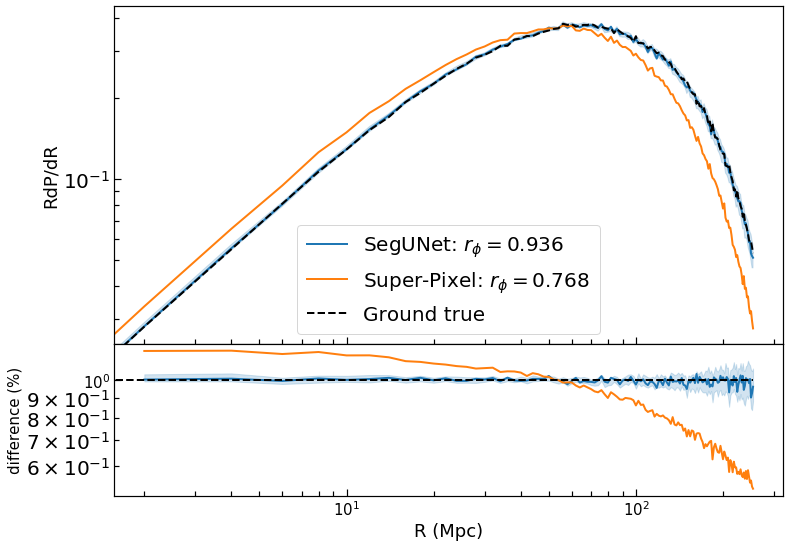

(None, None)

<Figure size 1440x720 with 0 Axes>

In [57]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

compare_ml = (mfp_pred_ml[1]/mfp_true[1])
compare_ml_tta = (mfp_tta[:,1,:]/mfp_true[1])
compare_sp = (mfp_pred_sp[1]/mfp_true[1])

# PLOTS
fig, ax0 = plt.subplots(figsize=(12, 9))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1.8]) # set height ratios for sublots

# THE FIRST SUBPLOT
ax0 = plt.subplot(gs[0])
#ax0.set_title('$z=%.3f$\t$x_n=%.3f$\t$r_{\phi}=%.3f$' %(z, np.mean(xH), phicoef_seg), fontsize=ls)
ax0.fill_between(mfp_pred_ml[0], np.min(mfp_tta[:,1,:], axis=0), np.max(mfp_tta[:,1,:], axis=0), color='tab:blue', alpha=0.2)
ax0.loglog(mfp_pred_ml[0], mfp_pred_ml[1], '-', color='tab:blue', label=r'SegUNet: $r_{\phi}=%.3f$' %phicoef_seg, lw=2)
ax0.loglog(mfp_pred_sp[0], mfp_pred_sp[1], '-', color='tab:orange', label=r'Super-Pixel: $r_{\phi}=%.3f$' %phicoef_sp, lw=2)
ax0.loglog(mfp_true[0], mfp_true[1], 'k--', label='Ground true', lw=2)
ax0.legend(loc=0, borderpad=0.5)
ax0.tick_params(axis='both', length=7, width=1.2)
ax0.tick_params(axis='both', which='minor', length=5, width=1.2)
ax0.set_ylabel('RdP/dR', size=18), ax0.set_xlabel('R (Mpc)')

# THE SECOND SUBPLOT
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.loglog(mfp_true[0], compare_ml, '-', lw=2)
ax1.loglog(mfp_true[0], compare_sp, '-', lw=2)
ax1.loglog(mfp_true[0], np.ones_like(mfp_true[0]), 'k--', lw=2)
ax1.fill_between(mfp_true[0], np.min(compare_ml_tta, axis=0), np.max(compare_ml_tta, axis=0), color='tab:blue', alpha=0.2)
ax1.tick_params(axis='both', length=7, width=1.2, labelsize=15)
ax1.set_ylabel('difference (%)', size=15)
ax1.set_xlabel('R (Mpc)', size=18)

# PLOT SETUP
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0.0)
ax1.tick_params(which='minor', axis='both', length=5, width=1.2)
plt.savefig('%sbs_comparison%s.png' %(outpath, name), bbox_inches='tight')
#plt.savefig(outpath+'bs_comparison_i%d.png' %index, bbox_inches='tight')
plt.show(), plt.clf()

# Calculate the Power Spectra

In [58]:
ps_true, ks_true = t2c.power_spectrum_1d(mask_xn, kbins=20, box_dims=256, binning='log')
ps_pred_sp, ks_pred_sp = t2c.power_spectrum_1d(X_sp, kbins=20, box_dims=256, binning='log')
ps_pred_ml, ks_pred_ml = t2c.power_spectrum_1d(X_seg, kbins=20, box_dims=256, binning='log')

ps_tta = np.zeros((X_tta.shape[0],20))
for i in range(0,X_tta.shape[0]):
    ps_tta[i], ks_pred_ml = t2c.power_spectrum_1d(np.round(X_tta[i]), kbins=20, box_dims=256, binning='log')


In [59]:
compare_ml = 100*(ps_pred_ml/ps_true-1)
compare_ml_tta = 100*(ps_tta/ps_true-1)
compare_sp = 100*(ps_pred_sp/ps_true-1)

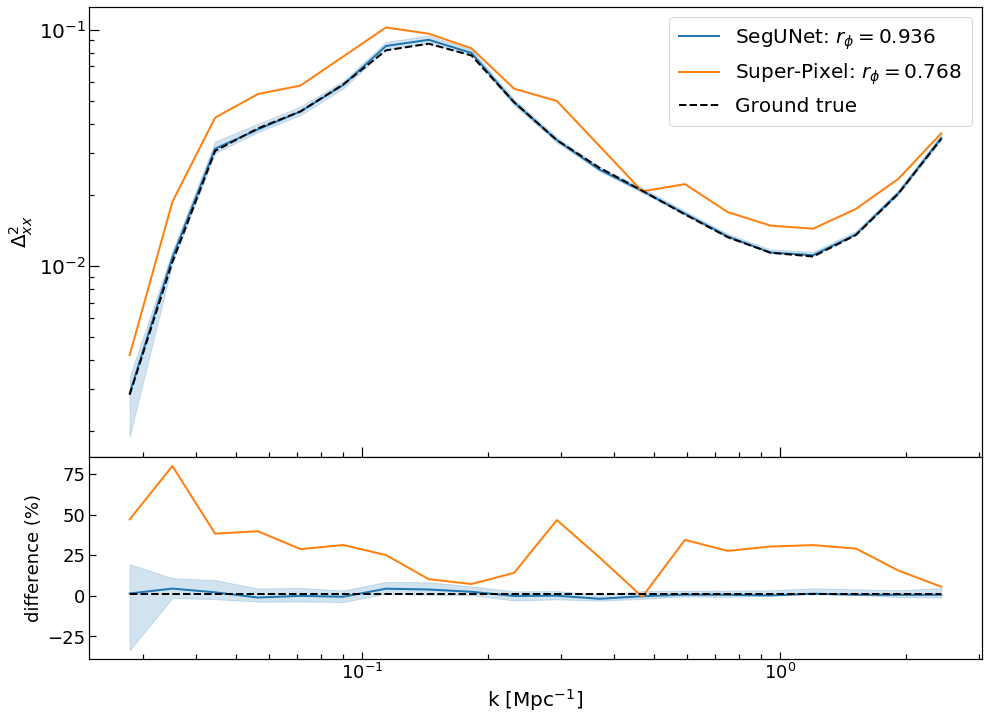

(None, None, None)

<Figure size 1440x720 with 0 Axes>

In [60]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

fig, ax = plt.subplots(figsize=(16, 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1.8])
ax0 = plt.subplot(gs[0])
#ax0.set_title('$z=%.3f$\t$x_n=%.3f$\t$r_{\phi}=%.3f$' %(z, np.mean(xH), phicoef_seg), fontsize=ls)
ax0.fill_between(ks_pred_ml, np.min(ps_tta*ks_pred_ml**3/2/np.pi**2, axis=0), np.max(ps_tta*ks_pred_ml**3/2/np.pi**2, axis=0), color='tab:blue', alpha=0.2)
ax0.loglog(ks_pred_ml, ps_pred_ml*ks_pred_ml**3/2/np.pi**2, '-', color='tab:blue', label=r'SegUNet: $r_{\phi}=%.3f$' %phicoef_seg, lw=2)
ax0.loglog(ks_pred_sp, ps_pred_sp*ks_pred_sp**3/2/np.pi**2, '-', color='tab:orange', label=r'Super-Pixel: $r_{\phi}=%.3f$' %phicoef_sp, lw=2)
ax0.loglog(ks_true, ps_true*ks_true**3/2/np.pi**2, 'k--', label='Ground true', lw=2)
ax0.set_yscale('log')
# THE SECOND SUBPLOT 
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.semilogx(ks_true, compare_ml, '-', lw=2)
ax1.semilogx(ks_true, compare_sp, '-', lw=2)
ax1.semilogx(ks_true, np.ones_like(ks_true), 'k--', lw=2)
ax1.fill_between(ks_true, np.min(compare_ml_tta, axis=0), np.max(compare_ml_tta, axis=0), color='tab:blue', alpha=0.2)

# PLOT SETUP
ax1.tick_params(axis='both', length=7, width=1.2, labelsize=18)
ax1.set_xlabel('k [Mpc$^{-1}$]', size=20), ax0.set_ylabel('$\Delta^2_{xx}$', size=20)
ax1.set_ylabel('difference (%)', size=18)
ax0.tick_params(axis='both', length=10, width=1.2)
ax0.tick_params(which='minor', axis='both', length=5, width=1.2)
ax1.tick_params(which='minor', axis='both', length=5, width=1.2)
ax0.legend(loc=0, borderpad=0.5)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0.0)
plt.savefig('%sPk_comparison%s.png' %(outpath, name), bbox_inches='tight'), plt.show(), plt.clf()

In [61]:
ds_data = np.vstack((ks_true, np.vstack((ps_true*ks_true**3/2/np.pi**2, np.vstack((np.vstack((ps_pred_ml*ks_pred_ml**3/2/np.pi**2, np.vstack((np.min(ps_tta*ks_pred_ml**3/2/np.pi**2, axis=0), np.max(ps_tta*ks_pred_ml**3/2/np.pi**2, axis=0))))), ps_pred_sp*ks_pred_sp**3/2/np.pi**2))))))
bsd_data = np.vstack((mfp_true[0], np.vstack((mfp_true[1], np.vstack((np.vstack((mfp_pred_ml[1], np.vstack((np.min(mfp_tta[:,1,:], axis=0), np.max(mfp_tta[:,1,:], axis=0))))), mfp_pred_sp[1]))))))

np.savetxt('%sds_data%s.txt' %(outpath, name), ds_data.T, fmt='%.6e', delimiter='\t', header='k [Mpc^-1]\tds_true\tds_seg_mean\tds_err_min\tds_err_max\tds_sp')
np.savetxt('%sbsd_data%s.txt' %(outpath, name), ds_data.T, fmt='%.6e', delimiter='\t', header='R [Mpc]\tbs_true\tbs_seg_mean\tb_err_min\tbs_err_max\tbs_sp')

## $r_{\phi}$  Matthews correlation coefficient

r_phi_seg = 0.871
r_phi_sp = 0.620


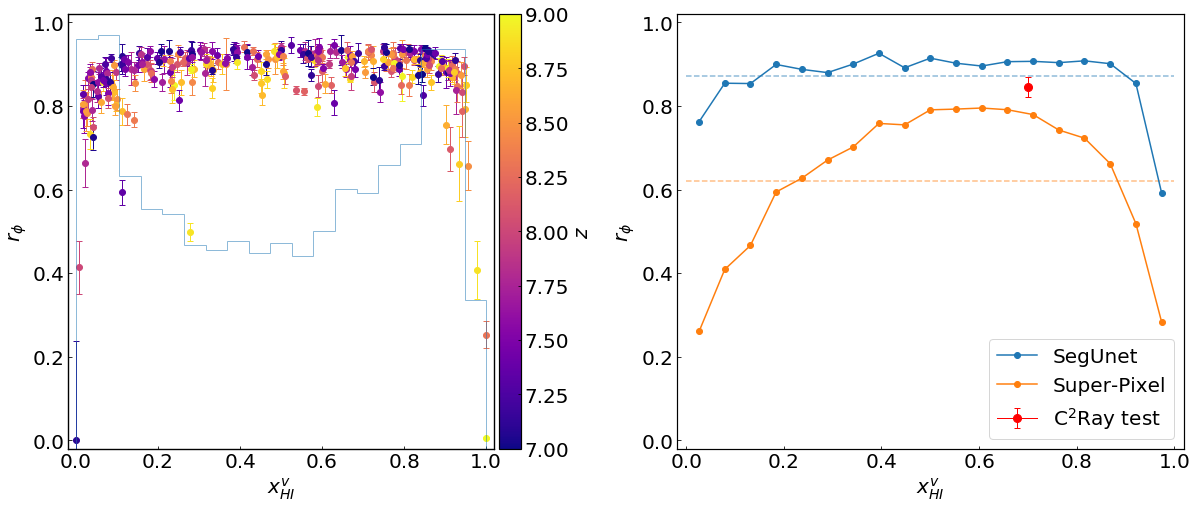

In [57]:
import matplotlib
import matplotlib.pyplot as plt, numpy as np
from myutils.utils import OrderNdimArray
from scipy.interpolate import interp1d, splev, splrep, UnivariateSpline

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 20

PATH_MODEL = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions_1/pred_tobs1000/'
redshift, xn_sim, phicoef_seg, phicoef_seg_err, phicoef_sp, xfrac = OrderNdimArray(np.loadtxt(PATH_MODEL+'astro_data.txt', unpack=True, usecols=(1,5,6,7,8,9)), 1)

xfrac_train = np.loadtxt('/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/data3D_128_030920/astro_params.txt', usecols=(6))

print('r_phi_seg = %.3f' %np.mean(phicoef_seg))
print('r_phi_sp = %.3f' %np.mean(phicoef_sp))

fig, (ax0, ax1) = plt.subplots(ncols=2)
#ax0.set_title('MCC SegUnet')

cm = matplotlib.cm.plasma
sc = ax0.scatter(xfrac, phicoef_seg, c=redshift, vmin=7, vmax=9, s=25, cmap=cm, marker='.')
norm = matplotlib.colors.Normalize(vmin=7, vmax=9, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cm)
redshift_color = np.array([(mapper.to_rgba(v)) for v in redshift])
for x, y, e, clr, red in zip(xfrac, phicoef_seg, phicoef_seg_err, redshift_color, redshift):
    ax0.errorbar(x, y, e, lw=1, marker='o', capsize=3, color=clr)
ax0.set_xlim(xfrac.min()-0.02, xfrac.max()+0.02), ax0.set_xlabel(r'$x^v_{HI}$', size=20)
ax0.set_ylim(-0.02, 1.02), ax0.set_ylabel(r'$r_{\phi}$', size=20)
fig.colorbar(sc, ax=ax0, pad=0.01, label=r'$z$')

ax2 = ax0.twinx()
h = ax2.hist(xfrac_train, np.linspace(1e-5, 1., 20), density=True, histtype='step', color='tab:blue', alpha=0.5)
#ax2.hist(xfrac, np.linspace(1e-5, 1., 20), density=True, histtype='step', color='tab:orange', alpha=0.5)
ax2.axes.get_yaxis().set_visible(False)

#ax1.set_title('MCC comparison')
ax1.hlines(y=np.mean(phicoef_seg), xmin=0, xmax=1, ls='--', alpha=0.5, color='tab:blue')
ax1.hlines(y=np.mean(phicoef_sp), xmin=0, xmax=1, ls='--', alpha=0.5, color='tab:orange')
new_x = np.linspace(xfrac.min(), xfrac.max(), 100)

new_x = h[1][:-1]+0.5*(h[1][1:]-h[1][:-1])
f1 = np.array([np.mean(phicoef_seg[(xfrac < h[1][i+1]) * (xfrac >= h[1][i])]) for i in range(h[1].size-1)])
ax1.plot(new_x, f1, label='SegUnet', color='tab:blue', marker='o')
f2 = np.array([np.mean(phicoef_sp[(xfrac < h[1][i+1]) * (xfrac >= h[1][i])]) for i in range(h[1].size-1)])
ax1.plot(new_x, f2, label='Super-Pixel', color='tab:orange', marker='o')
ax1.errorbar(0.7009, 0.845, 0.023, lw=1, markersize=8, marker='o', capsize=3, color='red', label=r'C$\rm ^2$Ray test')

ax1.set_xlim(xfrac.min()-0.02, xfrac.max()+0.02), ax1.set_xlabel(r'$x^v_{HI}$', size=20)
ax1.set_ylim(-0.02, 1.02), ax1.set_ylabel(r'$r_{\phi}$', size=20)
ax1.legend(loc=4)
plt.savefig('%sphi_coef.png' %PATH_MODEL, bbox_inches="tight")
plt.show()

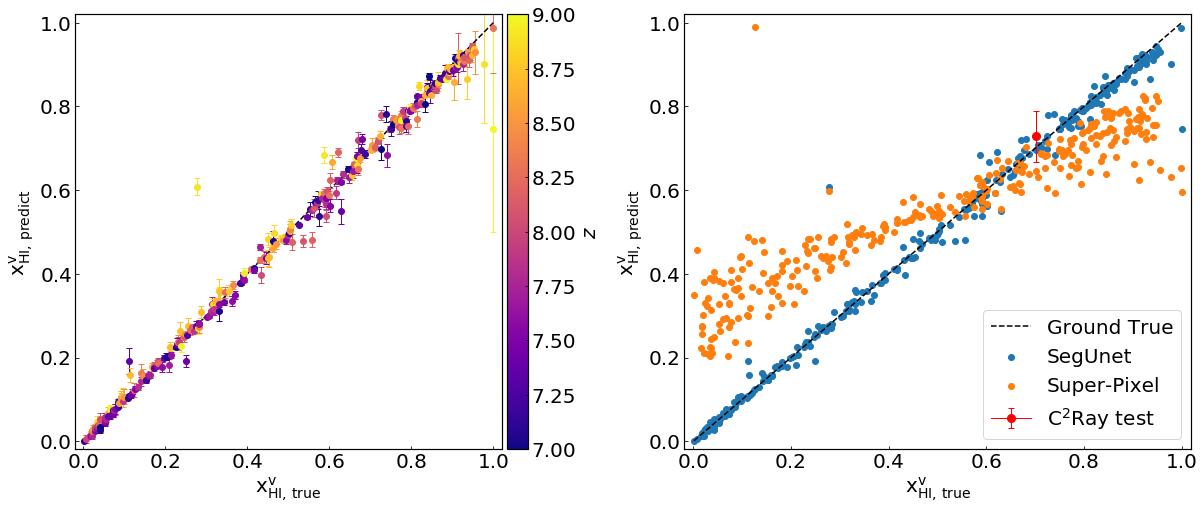

In [55]:
import matplotlib
import matplotlib.pyplot as plt, numpy as np
from myutils.utils import OrderNdimArray, RandomIndexes

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 20

PATH_MODEL = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions_1/pred_tobs1000/'
redshift, xn_mask_true, xn_seg, xn_seg_err, xn_sp = OrderNdimArray(np.loadtxt(PATH_MODEL+'astro_data.txt', unpack=True, usecols=(1,9,10,11,12)), 1)

fig, (ax0, ax1) = plt.subplots(ncols=2)
ax0.plot(xn_mask_true, xn_mask_true, 'k--')
cm = matplotlib.cm.plasma
sc = ax0.scatter(xn_mask_true, xn_seg, c=redshift, vmin=7, vmax=9, s=25, cmap=cm, marker='.')
norm = matplotlib.colors.Normalize(vmin=7, vmax=9, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap='plasma')
redshift_color = np.array([(mapper.to_rgba(v)) for v in redshift])
for x, y, e, clr in zip(xn_mask_true, xn_seg, xn_seg_err, redshift_color):
    ax0.errorbar(x, y, e, lw=1, marker='o', capsize=3, color=clr)
ax0.set_xlim(xn_mask_true.min()-0.02, xn_mask_true.max()+0.02), ax0.set_xlabel(r'$\rm x^v_{HI,\,true}$', size=20)
ax0.set_ylim(xn_mask_true.min()-0.02, xn_mask_true.max()+0.02), ax0.set_ylabel(r'$\rm x^v_{HI,\,predict}$', size=20)
fig.colorbar(sc, ax=ax0, pad=0.01, label=r'$z$')

ax1.scatter(xn_mask_true, xn_seg, color='tab:blue', marker='o', label='SegUnet')
#ax1.vlines(x=xn_mask_true, ymin=np.min([xn_seg, xn_mask_true], axis=0), ymax=np.max([xn_seg, xn_mask_true], axis=0), color='tab:blue', linewidths=0.1)
ax1.scatter(xn_mask_true, xn_sp, color='tab:orange', marker='o', label='Super-Pixel')
#ax1.vlines(x=xn_mask_true, ymin=np.min([xn_sp, xn_mask_true], axis=0), ymax=np.max([xn_sp, xn_mask_true], axis=0), color='tab:orange', linewidths=0.1)
ax1.plot(xn_mask_true, xn_mask_true, 'k--', label='Ground True')
ax1.errorbar(0.7009, 0.7287, 0.0604, lw=1, markersize=8, marker='o', capsize=3, color='red', label=r'C$\rm ^2$Ray test')

ax1.set_xlim(xn_mask_true.min()-0.02, xn_mask_true.max()+0.02), ax1.set_xlabel(r'$\rm x^v_{HI,\,true}$', size=20)
ax1.set_ylim(xn_mask_true.min()-0.02, xn_mask_true.max()+0.02), ax1.set_ylabel(r'$\rm x^v_{HI,\,predict}$', size=20)
plt.legend(loc=4)
plt.savefig('%scorr.png' %PATH_MODEL, bbox_inches="tight")

## Get intermediate layers output

## Get output of intermediate layer for Test Case

In [14]:
# load model
conf_file = '/home/michele/Documents/PhD_Sussex/output/ML/SegNet/tests/runs/'
conf_file += 'net2D_021020.ini'
model = LoadSegUnetModel(conf_file)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 Loaded model:
 /home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/model-sem21cm_ep56.h5


In [15]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import tools21cm as t2c, math
import sys
from myutils.plots import MergeImages

plt.rcParams['font.size'] = 5
plt.rcParams['figure.constrained_layout.use'] = False

def VisualizeLayersOutputs(model, X, y, path='./'):
    extrm = np.max([np.abs(np.min(X)), np.max(X)])
    for i in tqdm(range(len(model.layers))):
        layer = model.layers[i]
        inter_layer_model = Model(inputs=model.input, outputs=layer.output)
        
        if(i != 0):
            inter_layer_output = inter_layer_model.predict(X)

            colmn = 16
            row = inter_layer_output.shape[3]//colmn if(inter_layer_output.shape[3]//colmn != 0) else 1

            #if(inter_layer_output.shape[-1] != 1):

            for j in range(inter_layer_output.shape[-1]):
                if(row == 8):
                    plt.figure(figsize=(7,7))
                elif(row > 8):
                    plt.figure(figsize=(5,5))
                else:
                    plt.figure(figsize=(10,10))

                plt.imshow(np.array(inter_layer_output)[0,...,j], vmin=-extrm, vmax=extrm, origin='lower', cmap='seismic', extent=[0, inter_layer_output.shape[1], 0, inter_layer_output.shape[2]])
                plt.tick_params(axis='both', which='both', length=0, width=0, labelsize=0)
                plt.margins(0, 0)
                plt.savefig('%sfoo_h%d.png' %(path, j), bbox_inches="tight")
                plt.close('all')
            
            # Merge images togheter
            if(row == 1):
                arr_old_name = ['%sfoo_h%d.png' %(path, j) for j in range(inter_layer_output.shape[-1])]
                MergeImages(new_image_name='layer%d_%s' %(i, layer.name), old_image_name=arr_old_name, output_path=path, form='h', delete_old=False)
            else:
                arr_old_name = np.array(['%sfoo_h%d.png' %(path, j) for j in range(inter_layer_output.shape[-1])]).reshape(row, colmn)
                for r in range(row):
                    MergeImages(new_image_name='foo_v%d' %r, old_image_name=arr_old_name[r], output_path=path, form='h', delete_old=False)
                
                arr_old_name = ['%sfoo_v%d.png' %(path, r) for r in range(row)]
                MergeImages(new_image_name='layer%d_%s' %(i, layer.name), old_image_name=arr_old_name, output_path=path, form='v', delete_old=False)
                
        else:
            fig = plt.figure(figsize=(15,15))
            plt.imshow(X.squeeze(), vmin=-extrm, vmax=extrm, origin='lower', cmap='seismic', extent=[0, X.shape[1], 0, X.shape[2]])
            plt.contour(y.squeeze(), colors='lime', levels=[0.5], extent=[0, X.shape[1], 0, X.shape[2]])
            plt.tick_params(axis='both', which='both', length=0, width=0, labelsize=0)
            plt.margins(0, 0)
            plt.savefig('%slayer%d_%s.png' %(path, i, layer.name), bbox_inches="tight")
            plt.close('all')
        
        #t2c.save_cbin('%slayer%d.bin' %(path, i), np.array(inter_layer_output).squeeze())
    os.system("rm %sfoo*" %path)
    return np.array(inter_layer_output)

In [10]:
path_test = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/layers_output/layer_images/'
out_seg = VisualizeLayersOutputs(model=model, X=dT3[np.newaxis,:,64,:, np.newaxis], y=mask_xn[np.newaxis,:,64,:, np.newaxis] , path=path_test)

NameError: name 'model' is not defined

## Predict sphere

In [28]:
def sphere(shape, radius, position):
    semisizes = (radius,) * 3
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    arr = np.zeros(shape, dtype=float)
    
    for x_i, semisize in zip(position, semisizes):
        arr += (x_i / semisize) ** 2

    return arr <= 1.0

def Sphere(r=50):
    data = sphere((128, 128, 128), r, (64, 64, 64))
    return data.astype(float)

def Molecule():
    data = sphere((128, 128, 128), 50, (64, 64, 64)) \
            + sphere((128, 128, 128), 30, (32, 32, 32))\
            + sphere((128, 128, 128), 30, (96, 96, 96))\
            + sphere((128, 128, 128), 30, (32, 96, 96))\
            + sphere((128, 128, 128), 30, (32, 32, 96))\
            + sphere((128, 128, 128), 30, (32, 96, 32))\
            + sphere((128, 128, 128), 30, (32, 32, 96))\
            + sphere((128, 128, 128), 30, (96, 32, 32))\
            + sphere((128, 128, 128), 30, (96, 32, 96))\
            + sphere((128, 128, 128), 30, (96, 96, 32))
    return data.astype(float)

def SwissCheese(rs=[10,20], nrb=50):
    data = sphere((128, 128, 128), 5, (64, 64, 14))
    for i in range(nrb):
        radius = np.random.uniform(rs[0], rs[1])
        center = np.random.uniform(0, 128, size=3)
        data += sphere((128, 128, 128), radius, center)
    return data.astype(float)

def ManWithHat():
    hat = np.zeros((128, 128, 128))
    for i in range(128):
        for j in range(128):
            for k in range(128):
                if((i>=35 and i <= 40) and (j>=42 and j<=80) and (k>=17 and k<=64)):
                    hat[i,j,k] = 1
    data = sphere((128, 128, 128), 40, (75, 64, 64)) \
            + sphere((128, 128, 128), 18, (32, 60, 64)) \
            + sphere((128, 128, 128), 15, (64, 64, 94)) \
            + hat

    return data.astype(float)

def RescaleData(arr, a=-1, b=1):
    scaled_arr = (arr.astype(np.float32) - np.min(arr))/(np.max(arr) - np.min(arr)) * (b-a) + a
    return scaled_arr


x_n = 0.128	 z = 8.939
dT_mean=-0.007	dT_min=-7.325	dT_max=16.241


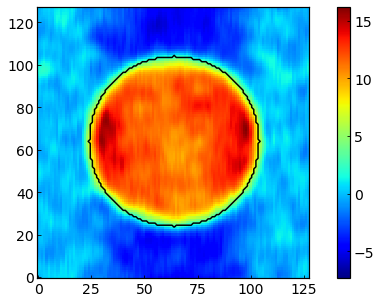

(None, None)

<Figure size 720x360 with 0 Axes>

In [29]:
data = Sphere(r=40)
#data = Molecule()
#data = SwissCheese(rs=[15,30], nrb=30)
#data = ManWithHat()
print('x_n = %.3f\t z = %.3f' %(np.mean(data), z))

dT_test = RescaleData(data, a=-8, b=8)
dT_test = t2c.subtract_mean_signal(dT_test, los_axis=2)
dT_test_smt = t2c.smooth_coeval(dT_test+noise_cube, z, box_size_mpc=cube.user_params.HII_DIM, max_baseline=2.0, ratio=1.0, nu_axis=2)

print('dT_mean=%.3f\tdT_min=%.3f\tdT_max=%.3f' %(np.mean(dT_test_smt), np.min(dT_test_smt), np.max(dT_test_smt)))

# Plot
plt.rcParams['figure.figsize'] = [10, 5]
plt.imshow(dT_test_smt[:,64,:], cmap='jet', origin='lower', vmin=np.min(dT_test_smt), vmax=np.max(dT_test_smt))
plt.colorbar()
plt.contour(data[:,64,:], colors='k', levels=[0.5])
plt.show(), plt.clf()

In [90]:
path_test  = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions_1/test_predict/layer_test2/'
out_seg = VisualizeLayersOutputs(model=model, X=dT_test_smt.astype(dtype='float64')[np.newaxis,:,64,:, np.newaxis], y=data.astype(int)[np.newaxis,:,64,:, np.newaxis] , path=path_test)

100%|██████████| 77/77 [50:41<00:00,  7.62s/it]


## Prediction Test

In [116]:
X = dT_test_smt[np.newaxis, ..., np.newaxis]
y = data.astype(int)

# SegUnet 2D
X1 = np.empty_like(dT3)
X2 = np.empty_like(dT3)
X3 = np.empty_like(dT3)
for i in tqdm(range(params['HII_DIM'])):
    X1[i,:,:] = model.predict(X[:,i,:,:,:], verbose=0).squeeze()  
    X2[:,i,:] = model.predict(X[:,:,i,:,:], verbose=0).squeeze()
    X3[:,:,i] = model.predict(X[:,:,:,i,:], verbose=0).squeeze()
X_seg = np.round((X1 + X2 + X3)/3.).astype(int)

"""
X_seg = np.empty_like(dT3)
X_seg[:,64,:] = model.predict(X[:,:,64,:,:], verbose=0).squeeze()
""";

100%|██████████| 128/128 [00:17<00:00,  7.39it/s]


In [117]:
# Super-Pixel
X = X.squeeze()
labels = t2c.slic_cube(X.astype(dtype='float64'), n_segments=5000, compactness=0.1, max_iter=20, sigma=0, min_size_factor=0.5, max_size_factor=3, cmap=None)
superpixel_map = t2c.superpixel_map(X, labels)
X_sp = 1-t2c.stitch_superpixels(X, labels, bins='knuth', binary=True, on_superpixel_map=True)

The output contains the labels created by SLIC with 5821 segments


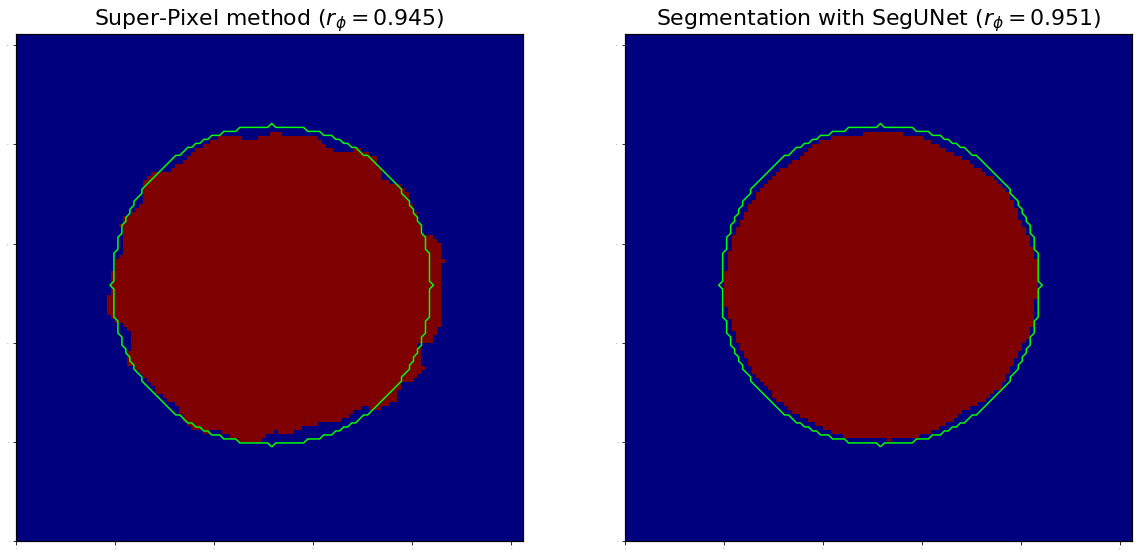

<Figure size 1440x720 with 0 Axes>

In [120]:
from sklearn.metrics import matthews_corrcoef

phicoef_seg = matthews_corrcoef(y.flatten(), X_seg.flatten())
phicoef_sp = matthews_corrcoef(y.flatten(), X_sp.flatten())

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 0

idx = params['HII_DIM']//2
#idx = 10

plt.subplot(121)
plt.title('Super-Pixel method ($r_{\phi}=%.3f$)' %phicoef_sp, size=ls)
plt.imshow(X_sp[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
plt.contour(y[:,idx,:], colors='lime', levels=[0.5], extent=my_ext)
plt.subplot(122)
plt.title(r'Segmentation with SegUNet ($r_{\phi}=%.3f$)' %phicoef_seg, size=ls)
plt.imshow(X_seg[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
plt.contour(y[:,idx,:], colors='lime', levels=[0.5], extent=my_ext)
plt.savefig(outpath+'test_visual_comparison.png', bbox_inches='tight')
plt.show()
plt.clf()


## prediction with $T_S$
create simulation box with spin temperature

In [3]:
z = 8.939
zeta = 65.204
Rmfp = 11.861
Tvir = 4.539
LX = 35

params = {'HII_DIM':128, 'DIM':384, 'BOX_LEN':256}
c_params = {'OMm':0.27, 'OMb':0.046, 'SIGMA_8':0.82, 'POWER_INDEX':0.96}
a_params = {'HII_EFF_FACTOR':zeta, 'R_BUBBLE_MAX':Rmfp, 'ION_Tvir_MIN':Tvir, 'L_X':LX}
my_ext = [0, params['BOX_LEN'], 0, params['BOX_LEN']]

ic = p21c.initial_conditions(user_params=params, cosmo_params=c_params, random_seed=2020)
pert_field = p21c.perturb_field(redshift=z, init_boxes=ic)
T_S = p21c.spin_temperature(perturbed_field=pert_field, astro_params=a_params, zprime_step_factor=1.05)
ionized_box = p21c.ionize_box(spin_temp=T_S, zprime_step_factor=1.05, z_heat_max=20.0)
cubeS = p21c.brightness_temperature(ionized_box=ionized_box, perturbed_field=pert_field, spin_temp=T_S)

print(' z = %.3f\t xn = %.3f' %(z, np.mean(ionized_box.xH_box)))

outpath = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/spin_test/'

 z = 8.939	 xn = 0.504


In [4]:
dT = cubeS.brightness_temp
xH = ionized_box.xH_box   # x_HI

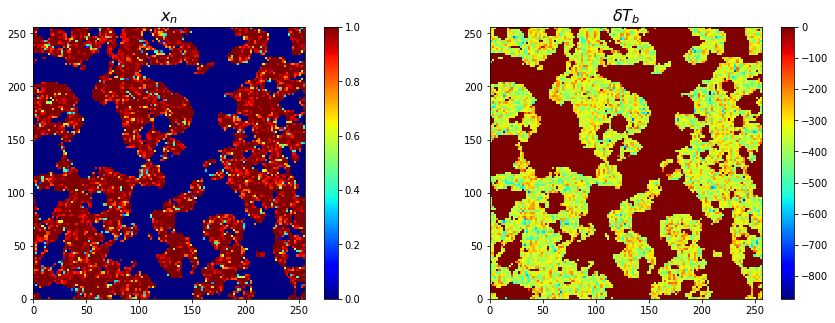

In [5]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.subplot(121)
plt.title('$x_n$', size=16)
plt.imshow(xH[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext, interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
#plt.contour(mask_xn[:,params['HII_DIM']//2,:], colors='lime', levels=[0.5], extent=my_ext)
plt.subplot(122)
plt.title(r'$\delta T_b$', size=16)
plt.imshow(dT[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext, interpolation='nearest')
plt.colorbar()
plt.savefig(outpath+'dTb_Ts.png', bbox_inches='tight')

In [6]:
smt_xn = t2c.smooth_coeval(xH, cubeS.redshift, box_size_mpc=cubeS.user_params.HII_DIM, max_baseline=2.0, ratio=1.0, nu_axis=2)
mask_xn = smt_xn > 0.5

In [7]:
# run onece (t~6-7min)
PATH_UV = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/'
if(os.path.exists(PATH_UV+'uv_coverage_%d/uvmap_z%.3f.npy' %(params['HII_DIM'], z)) and os.path.exists(PATH_UV+'uv_coverage_%d/Nantmap_z%.3f.npy' %(params['HII_DIM'], z))):
    uv = np.load(PATH_UV+'uv_coverage_%d/uvmap_z%.3f.npy' %(params['HII_DIM'], z))
    Nant = np.load(PATH_UV+'uv_coverage_%d/Nantmap_z%.3f.npy' %(params['HII_DIM'], z))
else:
    uv, Nant = t2c.get_uv_daily_observation(params['HII_DIM'], z,
                                        filename=None,      # If None, it uses the SKA-Low 2016 configuration.
                                        total_int_time=6.0, # Observation per day in hours.
                                        int_time=10.0,      # Time period of recording the data in seconds.
                                        boxsize=cparams['BOX_LEN'], declination=-30.0, verbose=False)

    np.save(PATH_UV+'uv_coverage_%d/uvmap_z%.3f.npy' %(params['HII_DIM'], z))
    np.save(PATH_UV+'uv_coverage_%d/Nantmap_z%.3f.npy' %(params['HII_DIM'], z))
    
#t = 1000
tobs = 1000

np.random.seed(seed)
noise_cube = t2c.noise_cube_coeval(params['HII_DIM'], z,
                                   depth_mhz=None,   #If None, estimates the value such that the final output is a cube.
                                   obs_time=tobs, filename=None, boxsize=params['BOX_LEN'],
                                   total_int_time=6.0, int_time=10.0, declination=-30.0, uv_map=uv,
                                   N_ant=Nant, verbose=True, fft_wrap=False)


dT1 = t2c.subtract_mean_signal(dT, los_axis=2)
dT2 = dT1 + noise_cube

# Smooth the data to resolution corresponding to maximum baseline of 2 km
dT3 = t2c.smooth_coeval(dT2, z, box_size_mpc=params['HII_DIM'], max_baseline=2.0, ratio=1.0, nu_axis=2)
print('...done')


Creating the noise cube...
...done


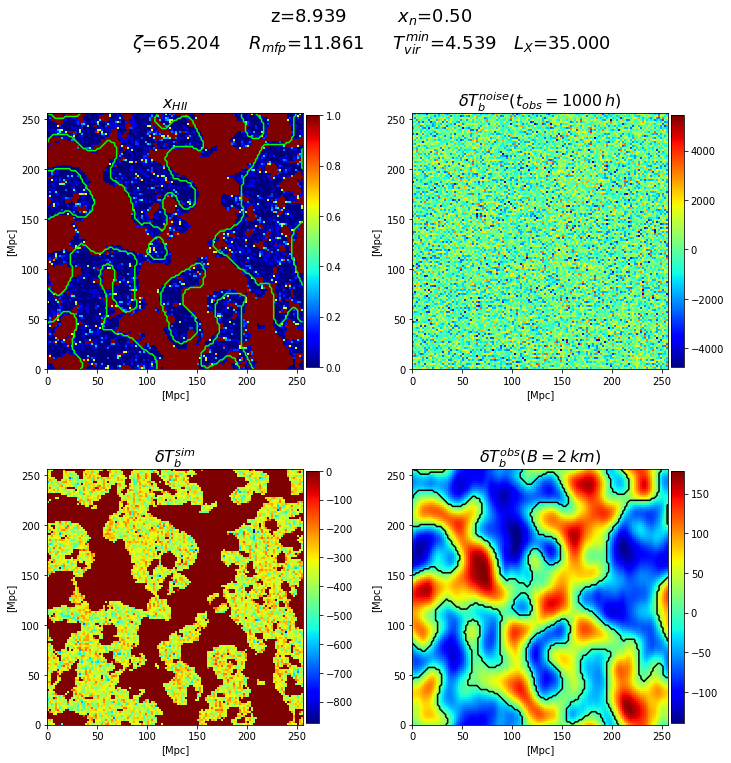

In [18]:
idx = 64

fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('z=%.3f\t\t$x_n$=%.2f\n$\zeta$=%.3f     $R_{mfp}$=%.3f     $T_{vir}^{min}$=%.3f   $L_{X}$=%.3f' %(z, np.mean(ionized_box.xH_box), zeta, Rmfp, Tvir, LX), fontsize=18)

axs[0,0].set_title('$x_{HII}$', size=16)
axs[0,0].contour(mask_xn[:,idx,:], colors='lime', levels=[0.5], extent=my_ext)
im = axs[0,0].imshow(1-xH[:,idx,:], origin='lower', cmap='jet', extent=my_ext, vmin=0, vmax=1)
axs[0,0].set_xlabel('[Mpc]'), axs[0,0].set_ylabel('[Mpc]');
fig.colorbar(im, ax=axs[0,0], pad=0.01, shrink=0.85)

axs[0,1].set_title('$\delta T^{noise}_b(t_{obs}=%d\,h)$' %tobs, size=16)
im = axs[0,1].imshow(dT2[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
axs[0,1].set_xlabel('[Mpc]'), axs[0,1].set_ylabel('[Mpc]');
fig.colorbar(im, ax=axs[0,1], pad=0.01, shrink=0.85)

axs[1,0].set_title('$\delta T^{sim}_b$', size=16)
im = axs[1,0].imshow(dT[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
axs[1,0].set_xlabel('[Mpc]'), axs[1,0].set_ylabel('[Mpc]');
fig.colorbar(im, ax=axs[1,0], pad=0.01, shrink=0.85)

axs[1,1].set_title('$\delta T^{obs}_b(B=2\,km)$', size=16)
im = axs[1,1].imshow(dT3[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
axs[1,1].contour(mask_xn[:,idx,:], colors='k', levels=[0.5], extent=my_ext)
axs[1,1].set_xlabel('[Mpc]'), axs[1,1].set_ylabel('[Mpc]');
fig.colorbar(im, ax=axs[1,1], pad=0.01, shrink=0.85)

plt.savefig(outpath+'cube21cm_Ts.png', bbox_inches='tight')

In [9]:
print(dT3.mean(), dT3.min(), dT3.max())

-0.011086416977279592 -159.78264812783806 182.29552076569868


In [10]:
from tensorflow.keras.models import load_model
from utils_network.metrics import iou, iou_loss, dice_coef, dice_coef_loss, balanced_cross_entropy, phi_coef
from config.net_config import NetworkConfig

def LoadSegUnetModel(cfile):
    avail_metrics = {'binary_accuracy':'binary_accuracy', 'iou':iou, 'dice_coef':dice_coef, 'iou_loss':iou_loss, 'dice_coef_loss':dice_coef_loss, 'phi_coef':phi_coef, 'mse':'mse', 'mae':'mae', 'binary_crossentropy':'binary_crossentropy', 'balanced_cross_entropy':balanced_cross_entropy}
    conf = NetworkConfig(conf_file)

    INPATH = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/data3D_128_061020/tobs1000/'
    PATH_OUT = conf.resume_path
    MODEL_EPOCH = conf.best_epoch
    METRICS = [avail_metrics[m] for m in np.append(conf.loss, conf.metrics)]
    cb = {func.__name__:func for func in METRICS if not isinstance(func, str)}
    model_loaded = load_model('%smodel-sem21cm_ep%d.h5' %(PATH_OUT+'checkpoints/', MODEL_EPOCH), custom_objects=cb)
    
    print(' Loaded model:\n %s' %(conf.resume_path))
    return model_loaded


# load model
conf_file = '/home/michele/Documents/PhD_Sussex/output/ML/SegNet/config/runs/'
conf_file += 'net2D_021020.ini'
model = LoadSegUnetModel(conf_file)

Using TensorFlow backend.


 Loaded model:
 /home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/


In [11]:
X = dT3[np.newaxis, ..., np.newaxis]
y = mask_xn.astype(int)

# SegUnet 2D
X1 = np.empty_like(dT3)
X2 = np.empty_like(dT3)
X3 = np.empty_like(dT3)
for i in tqdm(range(params['HII_DIM'])):
    X1[i,:,:] = model.predict(X[:,i,:,:,:], verbose=0).squeeze()  
    X2[:,i,:] = model.predict(X[:,:,i,:,:], verbose=0).squeeze()
    X3[:,:,i] = model.predict(X[:,:,:,i,:], verbose=0).squeeze()
X_seg = np.round((X1 + X2 + X3)/3.).astype(int)


100%|██████████| 128/128 [00:36<00:00,  2.67it/s]


In [12]:
# Super-Pixel
X = X.squeeze()
labels = t2c.slic_cube(X.astype(dtype='float64'), n_segments=5000, compactness=0.1, max_iter=20, sigma=0, min_size_factor=0.5, max_size_factor=3, cmap=None)
superpixel_map = t2c.superpixel_map(X, labels)
X_sp = 1-t2c.stitch_superpixels(X, labels, bins='knuth', binary=True, on_superpixel_map=True)

The output contains the labels created by SLIC with 5827 segments


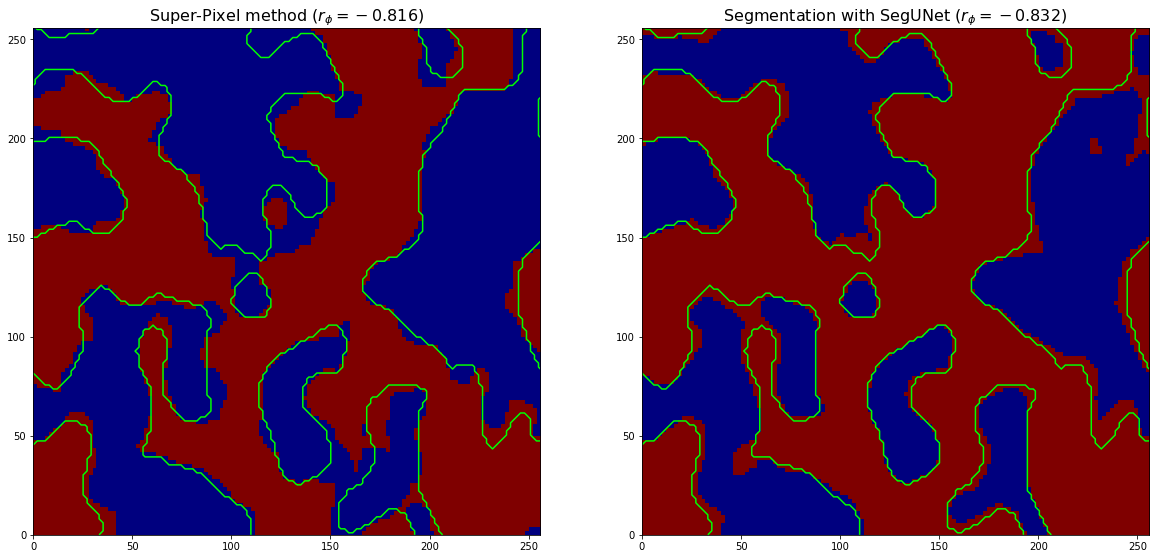

<Figure size 1440x720 with 0 Axes>

In [13]:
from sklearn.metrics import matthews_corrcoef

phicoef_seg = matthews_corrcoef(y.flatten(), X_seg.flatten())
phicoef_sp = matthews_corrcoef(y.flatten(), X_sp.flatten())

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['figure.figsize'] = [20, 10]

idx = params['HII_DIM']//2

plt.subplot(121)
plt.title('Super-Pixel method ($r_{\phi}=%.3f$)' %phicoef_sp, size=16)
plt.imshow(X_sp[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
plt.contour(y[:,idx,:], colors='lime', levels=[0.5], extent=my_ext)
plt.subplot(122)
plt.title(r'Segmentation with SegUNet ($r_{\phi}=%.3f$)' %phicoef_seg, size=16)
plt.imshow(X_seg[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
plt.contour(y[:,idx,:], colors='lime', levels=[0.5], extent=my_ext)
plt.savefig(outpath+'test_visual_comparison_Ts.png', bbox_inches='tight')
plt.show()
plt.clf()

In [65]:
import zipfile
import numpy as np
from glob import glob
from tqdm import tqdm
import tools21cm as t2c

PATH_INPUT = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/data3D_128_030920/'

astr_param = np.loadtxt(PATH_INPUT+'astro_params.txt')

xn_mask_train = np.zeros(10000)

for idx in tqdm(range(xn_mask_train.size)):
    z, xn = astr_param[idx,1], astr_param[idx,5]
    for i in range(1, 13):
        var = '%sdata3D_128_030920_part%d.zip' %(PATH_INPUT, i)

        content = np.loadtxt(PATH_INPUT+'content_part%d.txt' %i, dtype=int)
        if(idx in content):
            print(dirname, content)

            with zipfile.ZipFile(var, 'r') as myzip:
                f = myzip.extract(member='%s/data/xH_21cm_i%d.bin' %(var[var[:-5].rfind('/')+1:-4], idx), path=PATH_INPUT)
                xH = t2c.read_cbin(f)
                assert '%.3f' %np.mean(xH) == str(xn)
                smt_xn = t2c.smooth_coeval(xH, z, box_size_mpc=128, max_baseline=2.0, ratio=1.0, nu_axis=2)
                mask_xn = smt_xn>0.5
                xn_mask_train[idx] = np.mean(mask_xn)
                os.system('rm -r %s/' %var[:-4])  
                break

    new_astr_data = np.vstack((astr_param.T, xn_mask_train)).T

    t1 = '# HII_EFF_FACTOR: The ionizing efficiency of high-z galaxies\n'
    t2 = '# R_BUBBLE_MAX: Mean free path in Mpc of ionizing photons within ionizing regions\n'
    t3 = '# ION_Tvir_MIN: Minimum virial Temperature of star-forming haloes in log10 units\n'
    t4 = '#i\tz\teff_f\tRmfp\tTvir\tsim x_n\tmask x_n'
    np.savetxt('astro_params.txt', new_astr_data, header=t1+t2+t3+t4, fmt='%d\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f')


/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/data3D_128_030920/data3D_128_030920_part1.zip [   0    1    2 ... 6788 6789 6790]


In [67]:
assert '%.3f' %(0.5) == str(0.5), print('eerr')

eerr


AssertionError: None